In [14]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import fabio, sys, h5py
import sys, os
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.integrate import quad

sys.path.insert(0, '/Users/sharonberkowicz/Nextcloud/Research/Cryoprotectants/xrd/scripts')

In [15]:
# set path for working directory
os.chdir('/Users/sharonberkowicz/Nextcloud/Research/Cryoprotectants/xrd')
path=os.getcwd()
path

'/Users/sharonberkowicz/Nextcloud/Research/cryoprotectants/xrd'

In [16]:
from files_tools import*
from atomic_form_factor import*

In [17]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def line(x,a,b):
    return a*x+b


In [18]:
from lmfit.models import Model
def model_func(x, off, w): 
    return w*x-off

def model_func2(x, w): 
    return w*x


def subtr_offset(Iq, Iq_bg, w=1.):
    off = w*Iq_bg[-1] - Iq[-1]
    Iq_nobg = Iq - (w*Iq_bg-off)
    
    return Iq_nobg, w, off 


def subtr_offset2(Iq, Iq_bg):
    xfit = np.append(Iq_bg[15:30], Iq_bg[430:])
    yfit = np.append(Iq[15:30], Iq[430:])
    
    model = Model(model_func) 
    pars = model.make_params()
    pars['off'].set(100)
    pars['w'].set(0.3, min=0)
    
    fit_model = model.fit(yfit, params=pars, x=xfit) # fitted amplitude and backgr
    wfit = fit_model.params['w'].value
    off_fit = fit_model.params['off'].value
    
    Iq_npbg = Iq - (wfit*Iq_bg-off_fit)
    
    return Iq_npbg, wfit, off_fit

def subtr_offset1(Iq, Iq_bg):
    xfit = Iq_bg[15:30]
    yfit = Iq[15:30]

    model = Model(model_func) 
    pars = model.make_params()
    pars['off'].set(100)
    pars['w'].set(0.3, min=0)
    
    fit_model = model.fit(yfit, params=pars, x=xfit) # fitted amplitude and backgr
    wfit = fit_model.params['w'].value
    off_fit = fit_model.params['off'].value
    
    Iq_npbg = Iq - (wfit*Iq_bg-off_fit)
    
    return Iq_npbg, wfit, off_fit


def subtr_air(Iq, Iq_bg):
    xfit = np.append(Iq_bg[400:410],Iq_bg[430:])
    yfit = np.append(Iq[400:410],Iq[430:])
    
    model = Model(model_func) 
    pars = model.make_params()
    pars['off'].set(100)
    pars['w'].set(3, min=0)
    
    fit_model = model.fit(yfit, params=pars, x=xfit) # fitted amplitude and backgr
    wfit = fit_model.params['w'].value
    off_fit = fit_model.params['off'].value

    Iq_npbg = Iq - (wfit*Iq_bg-off_fit)
    
    return Iq_npbg, wfit , off_fit


def int_curve(x, y, a, b):
    interp_curve = interp1d(x, y, kind='cubic')
    return quad(lambda x: interp_curve(x), a, b)

In [19]:
Ih_ref = np.array([1.61297476, 1.71327851, 1.8264895 , 2.35318655, 2.79464445,
       3.03451657, 3.22634856, 3.27789344, 3.33837302, 3.6533046 ])

# ag-beh http://gisaxs.com/index.php/Material:Silver_behenate
ag_beh = [0.107625095, 0.215250189, 0.322875284, 0.430500378, 0.5380, 0.6456, 0.7532, 0.8608, 0.9684, 1.076, 1.184, 1.369, 1.387]

In [20]:
!ls '{path}/prepared_data/2021-06-28-dmso-wat-AuNP'

2021-06-28-dmso-wat-AuNP.hdf5


In [21]:
f = h5py.File(path+'/prepared_data/2021-06-28-dmso-wat-AuNP/2021-06-28-dmso-wat-AuNP.hdf5', 'r')
f.visititems(visit_func)   
f.close()

/Iq
	 /Iq/Iq_AuNP (512,)
	 /Iq/Iq_dmso20 (512,)
	 /Iq/Iq_dmso33 (6, 512)
	 /Iq/Iq_dmso33_quartz (512,)
	 /Iq/Iq_dmso67 (512,)
	 /Iq/Iq_wat (512,)
	 /Iq/Iq_wat_quartz (512,)
/img2d
	 /img2d/img2d_AuNP (1024, 1024)
	 /img2d/img2d_dmso20 (1024, 1024)
	 /img2d/img2d_dmso33 (6, 1024, 1024)
	 /img2d/img2d_dmso33_quartz (1024, 1024)
	 /img2d/img2d_dmso67 (1024, 1024)
	 /img2d/img2d_wat (1024, 1024)
	 /img2d/img2d_wat_quartz (1024, 1024)
/parameters
	 /parameters/t_exp ()
/temperature
	 /temperature/T (1,)
	 /temperature/T_dmso33 (6,)
/tool
	 /tool/Iq_blank_kapton (512,)
	 /tool/Iq_blank_quartz (512,)
	 /tool/Iq_calibrator (512,)
	 /tool/img2d_blank_kapton (1024, 1024)
	 /tool/img2d_blank_quartz (1024, 1024)
	 /tool/img2d_calibrator (1024, 1024)
	 /tool/mask (1024, 1024)
	 /tool/q (512,)


In [22]:
# -- to import the data

f = h5py.File(path+'/prepared_data/2021-06-28-dmso-wat-AuNP/2021-06-28-dmso-wat-AuNP.hdf5', 'r')

# visualize the h5 file structure
#f.visititems(visit_func)  

t_exp = np.asarray(f['/parameters/t_exp'])

q = np.asarray(f['/tool/q'])
mask = np.asarray(f['/tool/mask'])

Iq_agbeh = np.asarray(f['/tool/Iq_calibrator'])
Iq_bg = np.asarray(f['/tool/Iq_blank_kapton'])

Iq_wat = np.asarray(f['/Iq/Iq_wat'])
Iq_dmso33 = np.asarray(f['/Iq/Iq_dmso33'])
Iq_dmso20 = np.asarray(f['/Iq/Iq_dmso20'])
Iq_dmso67 = np.asarray(f['/Iq/Iq_dmso67'])
Iq_AuNP = np.asarray(f['/Iq/Iq_AuNP'])

T_dmso33 = np.asarray(f['/temperature/T_dmso33'])
T = np.asarray(f['/temperature/T'])

f.close()


############ air background ##################
f = h5py.File(path+'/prepared_data/2022-12-09/2022-12-09.hdf5', 'r')
q_air = np.asarray(f['/tool/q_50mm'])
Iq_air = np.asarray(f['/tool/Iq_air_50mm'])

In [23]:
# skinner et al 2013 (scattering intensity, cs subtracted)
water_ref = np.loadtxt('source/liq_water_xray_data_22C/ambient_water_xray_data.txt', skiprows=12, usecols=np.arange(2))
q_wat_ref = water_ref[10:130,0] 
Iq_wat_ref = water_ref[10:130,1]
#print(Iq_wat_ref.shape)
#q_wat_ref

In [24]:
cs_data = np.loadtxt('source/liq_water_xray_data_22C/compton_water.txt', skiprows=2) # from excel sheet
q_cs = cs_data[10:125,0]
cs = cs_data[10:125,-1]
cs_data.shape, q_cs[-1]

((1218, 6), 3.1)

In [25]:
data = np.loadtxt('source/liq_water_xray_data_22C/ambient_water_data_excel.txt', skiprows=1) # from excel sheet
q_wat_ref = data[10:125,0]
Iq_wat_ref = data[10:125,1] # 22C
ff = data[10:125,2]-cs

data.shape, q_wat_ref[-1]

((1041, 3), 3.1)

## q-calibrator

<IPython.core.display.Javascript object>


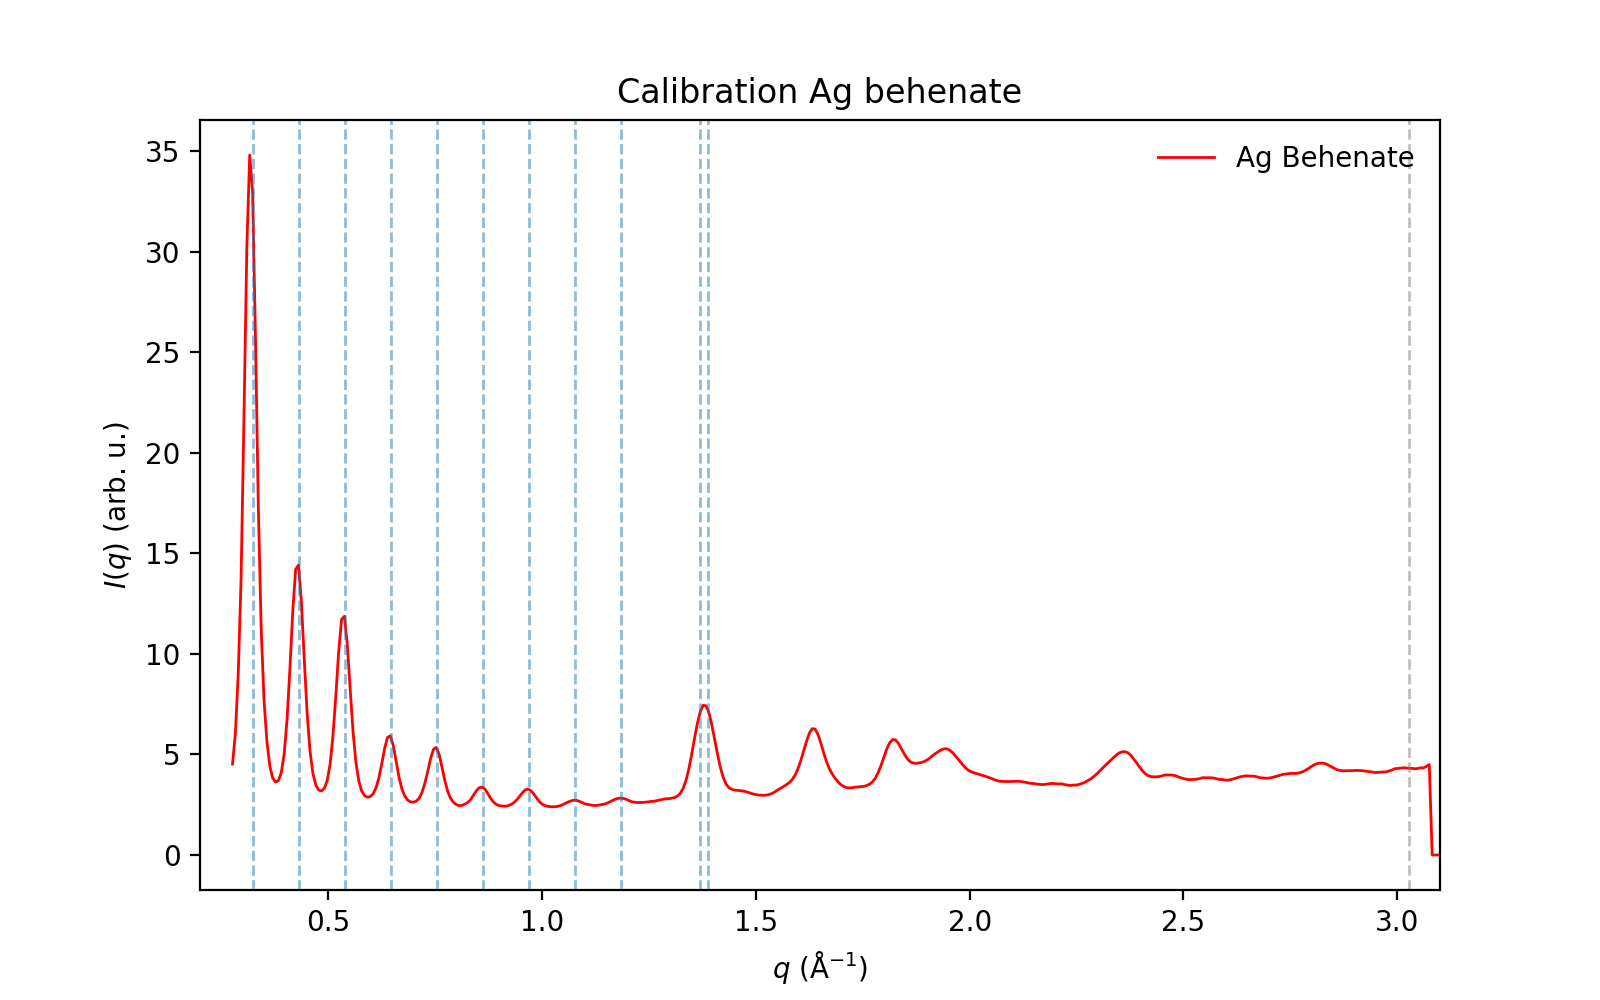

In [26]:
plt.figure(figsize=(8,5))

plt.plot(q,Iq_agbeh/t_exp,'-', lw =1,c='red',label = 'Ag Behenate',alpha=1)
for i in range(2,len(ag_beh)):
    plt.axvline(x = ag_beh[i],ls ='--', lw=1, alpha=0.5)
    
plt.axvline(x = q[410],ls ='--', c='grey', lw=1, alpha=0.5)
    
plt.xlim([0.2,3.1])
#plt.ylim([0.1,25])
#plt.yscale('log')
plt.xlabel(r'$q$ (Å$^{-1}$)')
plt.ylabel('$I(q)$ (arb. u.)')
plt.legend(frameon=False,fontsize=10, loc='upper right')
plt.title('Calibration Ag behenate')
plt.show()

## background

<IPython.core.display.Javascript object>


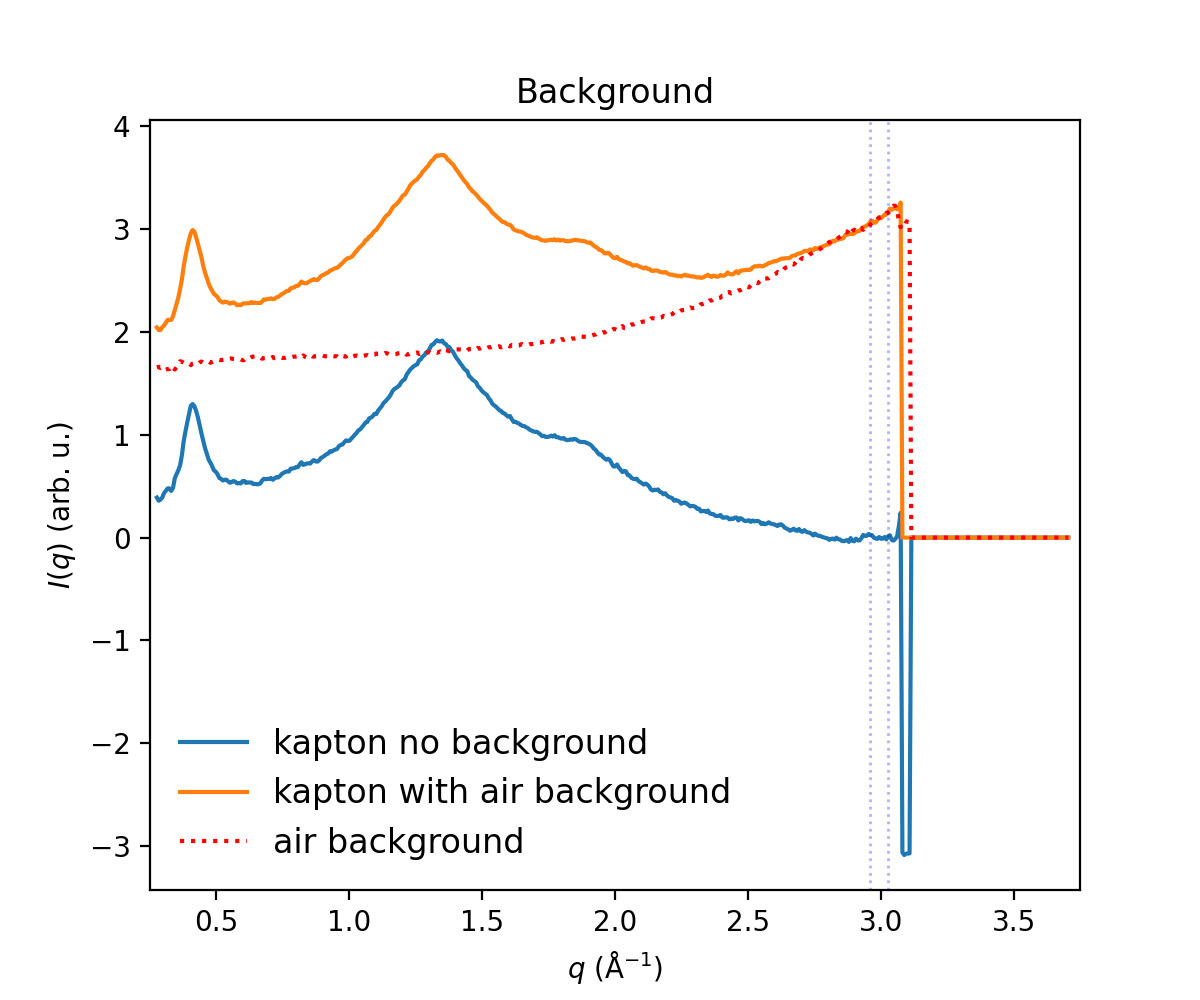

/var/folders/t0/b62grl953r99pk13mhcqq_v40000gn/T/ipykernel_61638/3041838816.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda x: interp_curve(x), a, b)


In [27]:
sample = 'kapton'
if sample == 'kapton':
    Iq=Iq_bg[:len(Iq_bg)]

plt.figure(figsize=(6,5))
    
Iq_kapton,w_air, off_air = subtr_air(Iq,Iq_air)
#Iq_kapton,w_air, off_air = subtr_offset(Iq,Iq_air,0.88)
#Iq_kapton = Iq-Iq_air 
Iq_kapton /= t_exp
Int_Iq_kapton,_ = int_curve(q, Iq_kapton, 0.66, 2.8)
#Iq_kapton /= Int_Iq_kapton
Iq_air_fitted = (w_air*Iq_air-off_air)
    
plt.plot(q, Iq_kapton, label=f'{sample} no background')
plt.plot(q, Iq/t_exp,ms=3, label=f'{sample} with air background')
plt.plot(q, (Iq_air_fitted)/t_exp, 'r:',label='air background')
plt.axvline(x=q[400], c='blue', lw=1, alpha=0.3,ls=':')
plt.axvline(x=q[410], c='blue', lw=1, alpha=0.3,ls=':')

plt.xlim([0.25,3.75])
plt.legend(frameon=False,fontsize=12)
plt.xlabel(r'$q$ (Å$^{-1}$)')
plt.ylabel('$I(q)$ (arb. u.)')
plt.title(f'Background')
plt.show()

## temperature dependence 33 mol% - Cu source and 1mm capillary

### check background subtraction

<IPython.core.display.Javascript object>


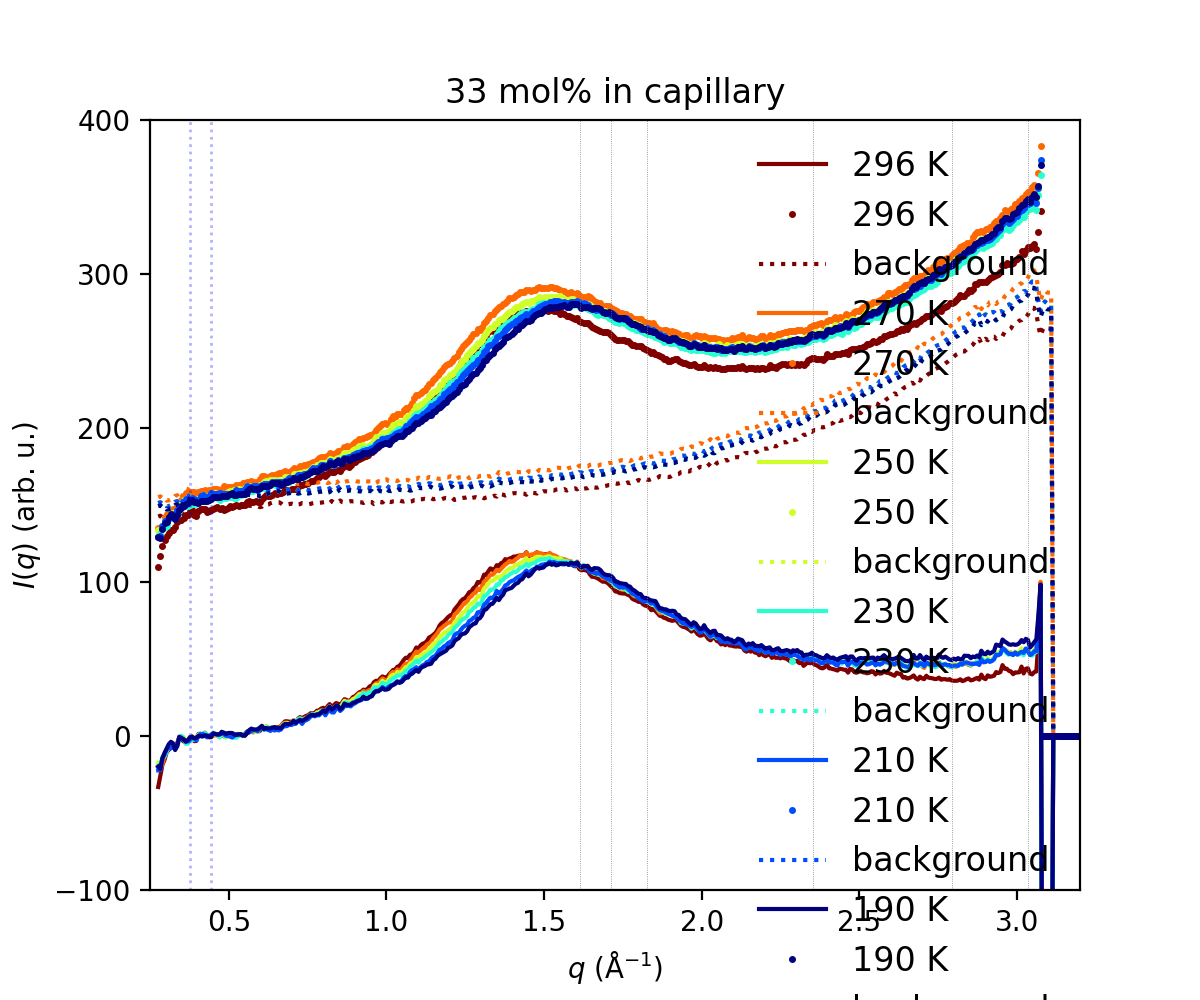

7.900347043232614e-13 -1.2126894694489042e-06


In [28]:
sample = '33'
if sample == '33':
    Iqs=Iq_dmso33[:len(Iq_dmso33)]
    Ts=T_dmso33[:len(Iq_dmso33)]

col = plt.cm.jet(np.linspace(1,0,len(Ts)))

plt.figure(figsize=(6,5))

for i in range(len(Ts)):
    
    if i==0:
        weight_air = 0.75
    else:
        weight_air = 0.8
        
    #Iqs_noair,w_air, offs_air = subtr_offset(Iqs[i],Iq_air,weight_air)
    #Iqs_nobg, w, offs = subtr_offset2(Iqs_noair,Iq_kapton)
    Iqs_noair,w_air,offs_air = subtr_offset2(Iqs[i],Iq_air)
    Iqs_nobg, w, offs = subtr_offset2(Iqs_noair,Iq_kapton)
    #Iqs_nobg /= t_exp
    #Int_Iqs,_ = int_curve(q, Iqs_nobg, 0.66, 2.8)
    
    Iq_air_fitted = (w_air*Iq_air-off_air)
    
    #plt.plot(q, Iq_air_fitted, ':', color=col[i], label='air background')
    plt.plot(q, Iqs_nobg, color=col[i], label='%.d K' %Ts[i])
    plt.plot(q, Iqs[i],'.', ms=3, color=col[i], label='%.d K' %Ts[i])  
    #plt.plot(q, (w*Iq_kapton-offs)/Int_Iqs, 'k:',label='background')
    plt.plot(q, Iq_air*w_air-offs_air, ':', color=col[i], label='background')
    
for i in range(len(Ih_ref)-4):
     plt.axvline(x=Ih_ref[i], c='gray', lw=0.3, alpha=1,ls=':')

plt.axvline(x=q[15], c='blue', lw=1, alpha=0.3,ls=':')
plt.axvline(x=q[25], c='blue', lw=1, alpha=0.3,ls=':')

plt.xlim([0.25,3.2])
plt.ylim(-100,400)
plt.legend(frameon=False,fontsize=12)
plt.xlabel(r'$q$ (Å$^{-1}$)')
plt.ylabel('$I(q)$ (arb. u.)')
plt.title(f'{sample} mol% in capillary')
plt.show()

print(w, offs)

### fit peak position

<IPython.core.display.Javascript object>


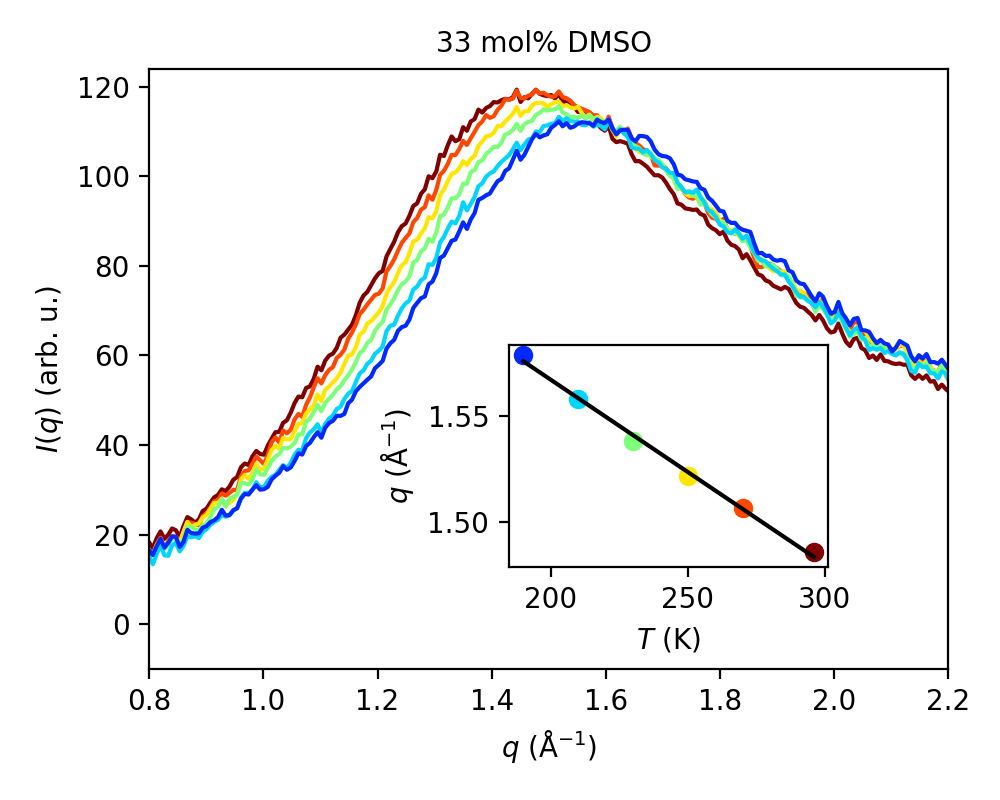

/var/folders/t0/b62grl953r99pk13mhcqq_v40000gn/T/ipykernel_61638/3041838816.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda x: interp_curve(x), a, b)


1.4860389523381072


In [58]:
fig, axs = plt.subplots(1,1, figsize=(5,4.))
axin = axs.inset_axes([0.45, 0.17, 0.4, 0.37])

for j in range(1):
    
    if j==0:
        Ts = T_dmso33
        Tstart = 0
        Tend = 0
        Iqs = Iq_dmso33
        xrange = 145,215
        qpos_guess = 1.45
        title = '33 mol% DMSO '
        shift=True

    peak_pos = []
    peak_int = []
    s=0
    
    for i in range(Tstart,len(Ts)-Tend):
        
        col = plt.cm.jet(np.linspace(1,0,len(Ts)-Tend+1)) 
        
        if i==0:
            weight_air = 0.75
        else:
            weight_air = 0.8
        
        #Iqs_noair,w_air, offs_air = subtr_offset(Iqs[i],Iq_air,weight_air)
        #y1, _, _ = subtr_offset2(Iqs_noair,Iq_kapton)/t_exp
        #y1,_,_ = subtr_offset2(Iqs[i],Iq_bg)/t_exp
        #y1,w,offs = subtr_offset2(Iqs[i],Iq_air)
        Iqs_noair,w_air,offs_air = subtr_offset2(Iqs[i],Iq_air)
        y1, w, offs = subtr_offset2(Iqs_noair,Iq_kapton)
        Int_y1,_ = int_curve(q, y1, 0.66, 2.8)
        #y1 /= Int_y1
        
        y = y1[xrange[0]+s*2:xrange[1]+s*2]
        x = q[xrange[0]+s*2:xrange[1]+s*2]
        
        popt, pcov = curve_fit(gauss_function, np.array(x), np.array(y), p0 = [2, qpos_guess, 0.5]) # fit peak with a gaussian
        peak_pos.append(popt[1]) # save peak positions
        peak_int.append(popt[0]) # save peak intensities
        if i==0:
            print(popt[1])
            
        axin.plot(Ts[i], peak_pos[i], '.',color=col[i], markersize=12)

        axs.plot(q, y1, '-', c=col[i] , markersize=3, label=f'{Ts[i]} K')
        #axs[0].plot(x, gauss_function(x, *popt), c=col[i], lw=1.5)
        
        #axs[0].axvline(x=x[0], lw=1, alpha=1,ls='--', c=col[i])
        #axs[0].axvline(x=x[-1], lw=1, alpha=1,ls='--', c=col[i])
        
        if shift==True:
            s+=1
            
    popt_line, pcov_line = curve_fit(line, np.array(Ts), np.array(peak_pos)) 
    axin.plot(Ts, line(Ts,*popt_line),'k-')

    axs.set_xlabel(r'$q$ ($\rm\AA^{-1}$)', fontsize=10)
    axs.set_ylabel(r'$I(q)$ (arb. u.)', fontsize=10)
    axs.set_xlim(0.8,2.2)
    axs.set_ylim(-10,y[:220].max()*1.1)
    #axs[0,j].set_xlim(x[0],x[-1])
    #axs[0,j].legend(frameon=False,fontsize=10)
    axs.set_title(title, size=10)
   # plt.xticks(fontsize=16), plt.yticks(fontsize=16)


    #axs[1,j].plot(Ts[Tstart:len(Ts)-Tend], peak_pos, '.-', markersize=12)
    #axs[1].set_xlim(180,350)
    axin.set_xlabel(r'$T$ (K)', fontsize=10)
    axin.set_ylabel(r'$q$ ($\rm\AA^{-1}$)', fontsize=10)
    #axs[1,j].set_xticks(fontsize=16), plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.savefig('/Users/sharonberkowicz/Nextcloud/Research/LCLS_XPP_XSVS_2023/peak_pos_33dmso.png',dpi=300)

plt.show()

<IPython.core.display.Javascript object>


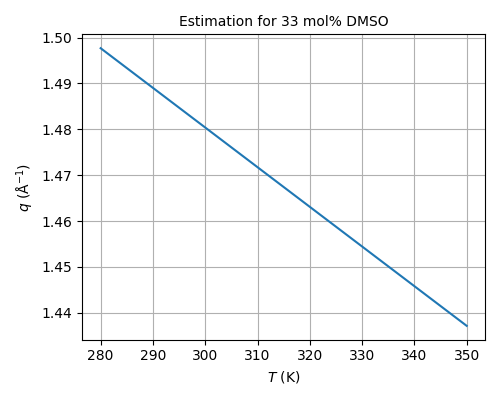

In [20]:
temps=np.linspace(280,350,100)

plt.figure(figsize=(5,4))

plt.plot(temps, line(temps,*popt_line), '-')

plt.xlabel(r'$T$ (K)', fontsize=10)
plt.ylabel(r'$q$ ($\rm\AA^{-1}$)', fontsize=10)
plt.title('Estimation for 33 mol% DMSO', size=10)
plt.tight_layout()
plt.grid()
plt.show()